# Robust linear regression on neuroanatomical measures of the PNC study subjects 
This notebook accompanies below paper: 

><span style="color:gray">F. Sepehrband\*, K.M. Lynch, R.P. Cabeen, C. Gonzalez-Zacarias, L. Zhao, M. D'Arcy, C. Kesselman, M.M. Herting, I.D. Dinov, A.W. Toga, K.A. Clark,   
**Neuroanatomical Morphometric Characterization of Sex Differences in Youth Using Multivariate Statistical Learning**,  
*NeuroImage*,   
submitted September 2017</span>.

In this notebook, we apply linear regression on FreeSurfer outputs of the PNC study using a robust linear regression technique.  

We plot negative log of the *p*-value, similar to the Manhattan plot of the GWAS analysis. Then, we implement a multivariate logistic regression on few most significant outcomes of the linear regression and report new statistics (significant level). In addition, we show an example that highlights the importance of dealing with outliers. To this end, we compare ordinary least square (OLS) fitting technique with robust fitting of the linear model (RLM).  

* Strucutral MRI of the [PNC study](http://www.med.upenn.edu/bbl/philadelphianeurodevelopmentalcohort.html ) were used for this study.  
* Morphological features of the strucutral images were derived using [FreeSurfer](http://freesurfer.net) toolkit.  
* FreeSurfer analysis was performed using [LONI pipeline](http://pipeline.loni.usc.edu) on high performance computing of <font color='red'>**USC**</font> Mark and Mary Stevens Neuroimaging and Informatics [Institute](http://www.ini.usc.edu), Keck school of Medicine of <font color='red'>**USC**</font>. The outputs were QC'ed and used as the input of this notebook. 

author:  
Farshid Sepehrband,   
*Laboratory of Neuro Imaging, USC Mark and Mary Stevens Neuroimaging and Informatics Institute, Keck School of Medicine of USC, University of Southern California, Los Angeles, CA, USA*
<farshid.sepehrband@loni.usc.edu>  
@fsepehrband


# Table of content
* [Importing required libraris](#lib)
* [Reading FreeSurfer's outputs](#input)  
* [Separating brain size, age, gender and race data](#separate)  
* [Robust Linear Modelling (Huber's loss with Trimmed estimator)](#rlm)  
    o [Plot results (NLogP)](#man-plot)  
    o [Multivarate logistic regression on top findings](#multi-log)
* [Comparing OLS and RLM (an example)](#ols-rlm)

## Importing required libraries <a class="anchor" id="lib"></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.plotly as py
import pandas as pd 
import os
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Read FreeSurfer's outputs <a class="anchor" id="input"></a>

In [2]:
myDir = '/Users/farshid/Dropbox/Research/Codes/GitHub/NeuroAnat_SexDiff'
os.chdir(myDir)
dataset = pd.read_csv('../NeuroAnat_SexDiff_data/pnc_withNames.csv')

## dataset has extra quotation mark in the names, so:
dataset.columns = dataset.columns.str.replace('\'',"")

# remove rows with NaN values
tempo = dataset.isnull().sum(axis=1)
indx_nan = list(np.where(tempo >= 1))
dataset.drop(dataset.index[indx_nan],inplace=True)

# check input dataframe
dataset.head()

,FreeSurfer:FS_aparc_2009:ctx_lh_G_and_S_frontomargin:L:area:,FreeSurfer:FS_aparc_2009:ctx_lh_G_and_S_occipital_inf:L:area:,FreeSurfer:FS_aparc_2009:ctx_lh_G_and_S_paracentral:L:area:,FreeSurfer:FS_aparc_2009:ctx_lh_G_and_S_subcentral:L:area:,FreeSurfer:FS_aparc_2009:ctx_lh_G_and_S_transv_frontopol:L:area:,FreeSurfer:FS_aparc_2009:ctx_lh_G_and_S_cingul-Ant:L:area:,FreeSurfer:FS_aparc_2009:ctx_lh_G_and_S_cingul-Mid-Ant:L:area:,FreeSurfer:FS_aparc_2009:ctx_lh_G_and_S_cingul-Mid-Post:L:area:,FreeSurfer:FS_aparc_2009:ctx_lh_G_cingul-Post-dorsal:L:area:,FreeSurfer:FS_aparc_2009:ctx_lh_G_cingul-Post-ventral:L:area:,...,FreeSurfer:FS_wmparc:Left-UnsegmentedWhiteMatter:L:volume:,FreeSurfer:FS_wmparc:Right-UnsegmentedWhiteMatter:R:volume:,FreeSurfer:FS_wmparc:lhCorticalWhiteMatterVol:N:volume:,FreeSurfer:FS_wmparc:rhCorticalWhiteMatterVol:N:volume:,FreeSurfer:FS_wmparc:CorticalWhiteMatterVol:N:volume:,FreeSurfer:FS_wmparc:MaskVol:N:volume:,FreeSurfer:FS_wmparc:EstimatedTotalIntraCranialVol:N:volume:,Age,Race,Gender
1,826.0,1080.0,859.0,895.0,553.0,1458.0,723.0,715.0,296.0,158.0,...,24579.1,26153.7,206855.0,208131.0,414986.0,1512450.0,1412750.0,187.0,1,1
2,679.0,900.0,900.0,1022.0,563.0,1682.0,981.0,863.0,321.0,163.0,...,21214.1,21127.0,199791.0,201670.0,401461.0,1498870.0,1420220.0,190.0,1,1
3,687.0,1524.0,858.0,1230.0,420.0,1841.0,1022.0,952.0,495.0,257.0,...,27110.0,27824.2,223792.0,227071.0,450863.0,1752370.0,1557320.0,242.0,0,0
4,765.0,876.0,971.0,978.0,344.0,1352.0,708.0,727.0,300.0,184.0,...,25375.2,25817.9,196285.0,199616.0,395901.0,1541160.0,1499480.0,137.0,0,1
5,712.0,780.0,903.0,1015.0,625.0,1543.0,840.0,805.0,354.0,159.0,...,18468.7,19526.6,187218.0,190497.0,377715.0,1505570.0,1419150.0,139.0,0,0


## Separating brain size, age, gender and self-identified race info <a class="anchor" id="separate"></a>
Now we start prepare the data for the regression analysis.  
For the ease of use, neuroimaging data are separated from demographic information. The estimated total intracranial volume was also separated to be added as a covariate to the regression analysis. 

In [3]:
eTIV_name = [col for col in list(dataset) if 'EstimatedTotalIntraCranialVol:N:volume' in col][0]
temp = [col for col in list(dataset) if col.startswith('FreeSurfer')]
temp.remove(eTIV_name)
nimg = dataset[temp]

temp = [col for col in list(dataset) if 'FreeSurfer' not in col]
temp.remove('Gender')
conf = dataset[temp]
conf = pd.concat([conf, dataset[eTIV_name]],axis=1)
conf.rename(columns = {eTIV_name:'eTIV'}, inplace = True)

pheno = dataset['Gender']
pd.concat([conf,pheno],axis=1).describe()

,Age,Race,eTIV,Gender
count,967.000000,967.000000,9.670000e+02,967.000000
mean,176.674249,0.458118,1.520103e+06,0.514995
std,40.995789,0.498501,1.703410e+05,0.500034
min,99.000000,0.000000,8.802730e+05,0.000000
25%,142.500000,0.000000,1.407205e+06,0.000000
50%,179.000000,0.000000,1.522930e+06,1.000000
75%,210.000000,1.000000,1.640820e+06,1.000000
max,271.000000,1.000000,1.986020e+06,1.000000


## Robust linear regression <a class="anchor" id="rlm"></a>
For linear regression, following model was used:  
  
> $\beta_0 + \beta_1 \times AGE + \beta_2 \times GENDER + \beta_3 \times eTIV + ... = IDP$  

IDP: Imaging derived phenotype

#### Robust linear model was implemented to deal with the outliers,
It was implemented by minimizing Huber's loss function, using least trimmed squares estimator. See method section of the paper for more info.  

*PS: Both categorical columns (gender and race) are binary, so no need for dummy coding.*

In [4]:
warnings.filterwarnings("ignore",category =RuntimeWarning)
import statsmodels.api as sm

# create an output data frame to store beta value, t-stat, p-value and -log(p-value)
output = pd.DataFrame(np.empty((nimg.shape[1],9)),index=list(nimg))
output.columns = ['software', 'atlas', 'region', 'hemisphere', 'neuro-param',\
                  'beta','t-stat','p-value','NLogP']

X = pd.concat([conf,pheno], axis=1)
X['intercept'] = np.ones((X.shape[0],1))

for ni in range(nimg.shape[1]):
    out_names = output.index[ni].split(':')
    output.loc[list(nimg)[ni],'software':'neuro-param'] = out_names[0:5]
    
    y = nimg.iloc[:,ni]
    trimmed = sm.RLM(y, X, M=sm.robust.norms.TrimmedMean())

    # Four columns that contian only zero values, resulted "singularity error" in robust regression fitting (in measuring covariance).
    # These columns are ignored.
    try:
        results = trimmed.fit(scale_est=sm.robust.scale.HuberScale(), cov="H2")
    except:
        results = trimmed.fit(scale_est=sm.robust.scale.HuberScale(), cov="H1")
        print('Ignoring  '+output.index[ni])
    
    # save regression results
    output.loc[list(nimg)[ni],'beta'] = results.params['Gender']
    output.loc[list(nimg)[ni],'t-stat'] = results.tvalues['Gender']
    output.loc[list(nimg)[ni],'p-value'] = results.pvalues['Gender']
    output.loc[list(nimg)[ni],'NLogP'] = -np.log10(results.pvalues['Gender'])
    
output.index=range(nimg.shape[1])
output.beta = np.round(output.beta,decimals=2)
output.NLogP = np.round(output.NLogP,decimals=2)
output['t-stat'] = np.round(output['t-stat'],decimals=2)
output.head()

/Users/Farshid/anaconda/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning:

The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.



Ignoring  FreeSurfer:FS_aseg:Left-WM-hypointensities:L:volume:
Ignoring  FreeSurfer:FS_aseg:Right-WM-hypointensities:R:volume:
Ignoring  FreeSurfer:FS_aseg:Left-non-WM-hypointensities:L:volume:
Ignoring  FreeSurfer:FS_aseg:Right-non-WM-hypointensities:R:volume:


,software,atlas,region,hemisphere,neuro-param,beta,t-stat,p-value,NLogP
0,FreeSurfer,FS_aparc_2009,ctx_lh_G_and_S_frontomargin,L,area,-48.64,-6.31,2.849349e-10,9.55
1,FreeSurfer,FS_aparc_2009,ctx_lh_G_and_S_occipital_inf,L,area,-40.73,-3.23,1.248978e-03,2.90
2,FreeSurfer,FS_aparc_2009,ctx_lh_G_and_S_paracentral,L,area,-35.76,-4.02,5.890281e-05,4.23
3,FreeSurfer,FS_aparc_2009,ctx_lh_G_and_S_subcentral,L,area,-53.77,-5.42,5.893751e-08,7.23
4,FreeSurfer,FS_aparc_2009,ctx_lh_G_and_S_transv_frontopol,L,area,-18.35,-3.01,2.649847e-03,2.58


### Plotting the -$log(p)$ for the "gender" covariate<a class="anchor" id="man-plot"></a>
For color-coding information, see caption of figure XXX. @TODO: update this after publication. 

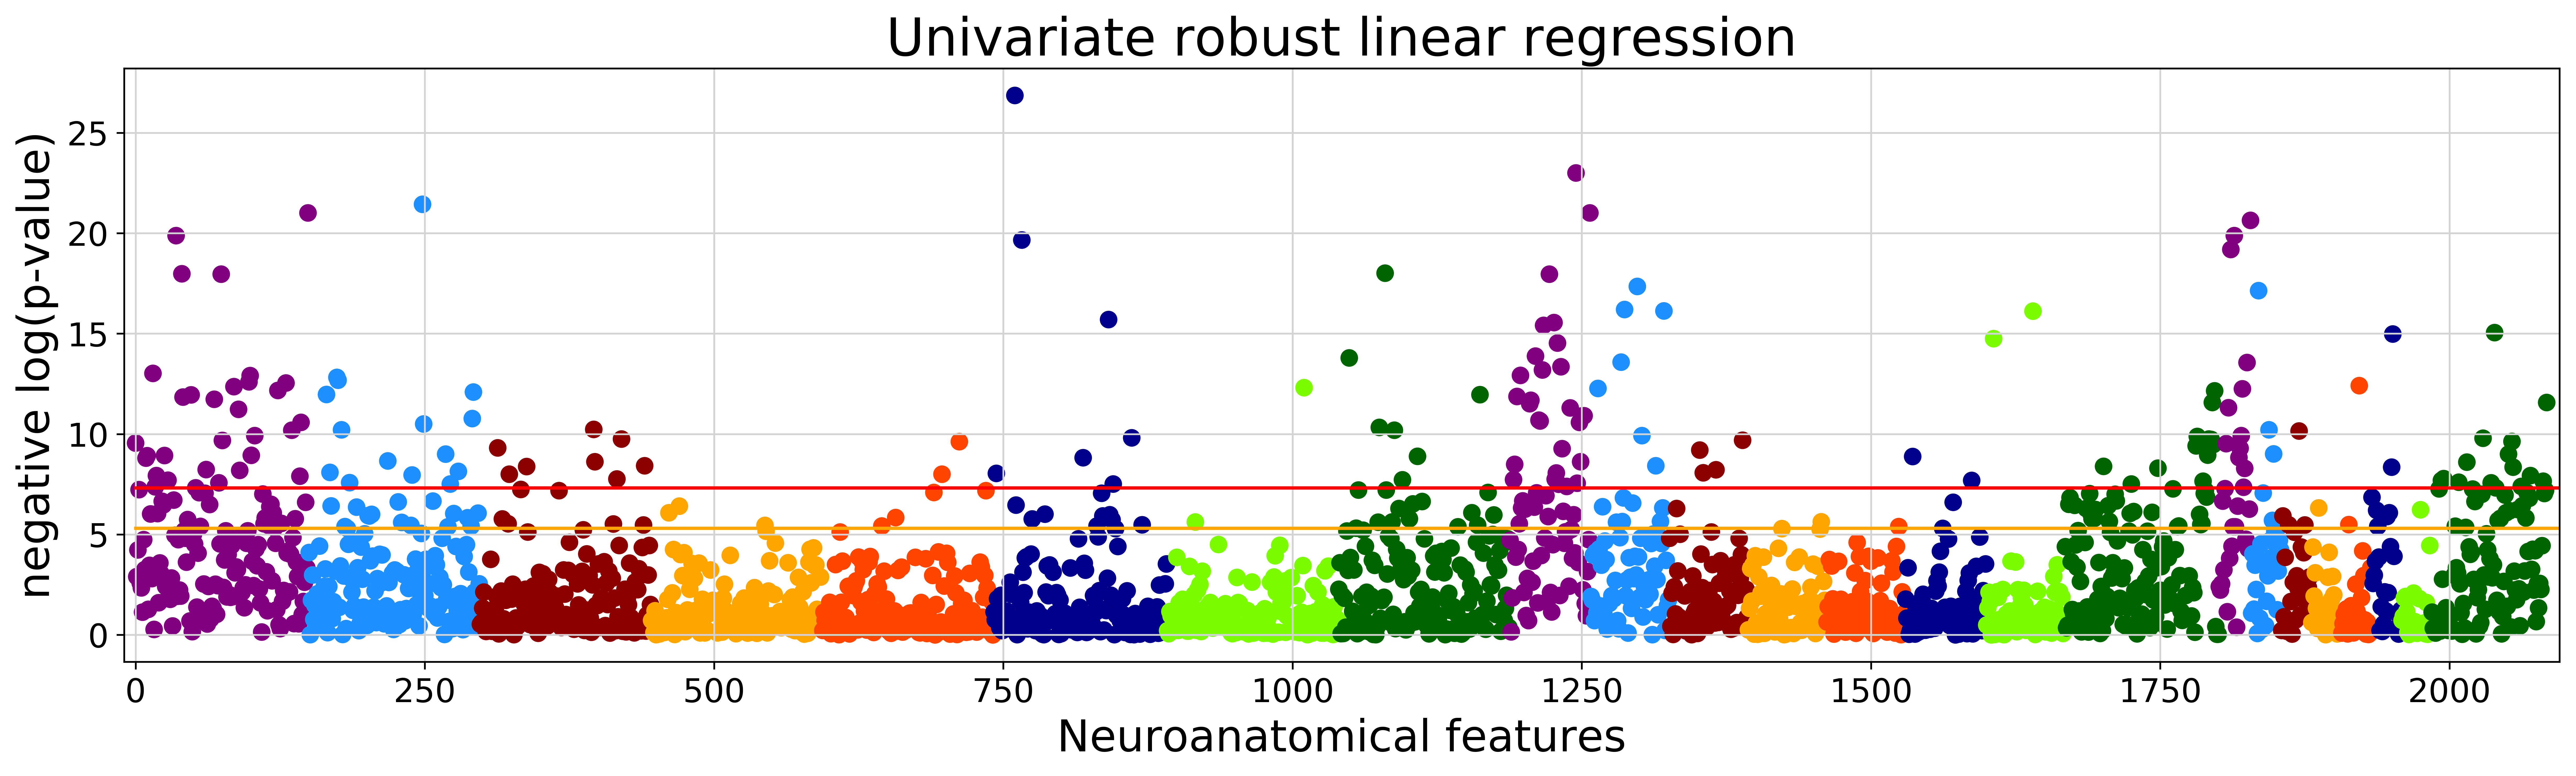

In [5]:
# define p-value threshold and determine Bonferoni threshold
Pval  = 0.01
Pval0 = 0.0001
Bonf  = -np.log10(Pval/len(output.index))
Bonf0 = -np.log10(Pval0/len(output.index))

# scatter plot results and draw Bonferoni line
fig = plt.figure(figsize=[20,5],dpi=600)
ax = fig.add_subplot(1, 1, 1,xlim=[-100,2200],facecolor='white')
ax.grid(color='lightgray')

def color_coding(features):
    face_color = ['darkred']*len(features)
    for i in range(len(features)):
        if features[i] == 'area':
            face_color[i] = 'purple'
        elif features[i] == 'curvind':
            face_color[i] = 'dodgerblue'
        elif features[i] == 'thickness':
            face_color[i] = 'darkblue'
        elif features[i] == 'volume':
            face_color[i] = 'darkgreen'
        elif features[i] == 'gauscurv':
            face_color[i] = 'orange'
        elif features[i] == 'meancurv':
            face_color[i] = 'orangered'
        elif features[i] == 'thicknessstd':
            face_color[i] = 'lawngreen'
    return face_color;
face_color = color_coding(output['neuro-param'])

ax.scatter(range(len(output.index)),output['NLogP'],label='-log(p)',c = face_color,s=50,edgecolor=face_color)
ax.plot([0,2500],[Bonf, Bonf],c='orange',label='Bonferoni')
ax.plot([0,2500],[Bonf0, Bonf0],c='red',label='Bonferoni')
plt.xlabel('Neuroanatomical features',size=20)
plt.ylabel('negative log(p-value)',size=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim((-10,len(output)+10))
plt.title('Univariate robust linear regression',fontsize=24)
plt.show()

### Multivariate GLM on most significant coritcal surface areas from Destrieux atlas <a class="anchor" id="multi-log"></a>
Here we performed a logistic regression on 4 most significant coritical surface area statistics of above figure ($-log(p)>15$):
> <font color='purple'>**purple**</font> pints on the left side of the above plot.

The query code for extracting these regions is:
```python
output.loc[(output['neuro-param']=='area') & (output['atlas']=='FS_aparc_2009') & (output['NLogP']>15)]
```
which returns: 
* ctx_lh_G_temp_sup-Plan_tempo
* ctx_lh_Lat_Fis-post
* ctx_lh_WhiteSurfArea
* ctx_rh_WhiteSurfArea

Therefore, we wrote: 
> $logit(gender)=\beta _{0}+\beta _{1}eTIV+\beta _{2}RACE+\beta _{3}AGE+\sum_{i=1}^{4}\beta _{i+3}IDP_{i}$

In [6]:
temp = output.loc[(output['neuro-param']=='area') & (output['atlas']=='FS_aparc_2009') & (output['NLogP']>15)].index
X_temp = nimg.iloc[:,temp]
name = list()
for i in range(len(list(X_temp))):
    name.append('-'.join(list(X_temp)[i].split(':')[2:4]))

X_temp.columns = name
X_multivar = pd.concat([X_temp,conf],axis=1)
X_multivar['intercept']=1
X_multivar
multivariate_test = sm.Logit(pheno, X_multivar).fit(disp=0)
print(multivariate_test.summary())

                           Logit Regression Results                           
Dep. Variable:                 Gender   No. Observations:                  967
Model:                          Logit   Df Residuals:                      959
Method:                           MLE   Df Model:                            7
Date:                Thu, 31 Aug 2017   Pseudo R-squ.:                  0.3069
Time:                        12:18:19   Log-Likelihood:                -464.25
converged:                       True   LL-Null:                       -669.84
                                        LLR p-value:                 9.532e-85
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
ctx_lh_G_temp_sup-Plan_tempo-L    -0.0013      0.001     -1.631      0.103      -0.003       0.000
ctx_lh_Lat_Fis-post-L             -0.0019      0.001     -2.051      0.

** Note that two of the *p*-values are not significant: **
> $P_{\beta_1} = 0.1$  
> $P_{\beta_3} = 0.14$

## Comparing OLS and RLM on using only *age* as predictor <a class="anchor" id="ols-rlm"></a>
To show the effect of outliers on derived measures, we compare ordinary least square linear regression with robust linear regression. For better visualization, only age is used as covariate and results are plotted based on it.  
We also compared few different approaches of robust fitting and noticed minimal difference.

                OLS    HuberT      Wave   Trimmed
Age       -0.000694 -0.000297 -0.000273 -0.000228
intercept  0.234419  0.133935  0.129229  0.118912


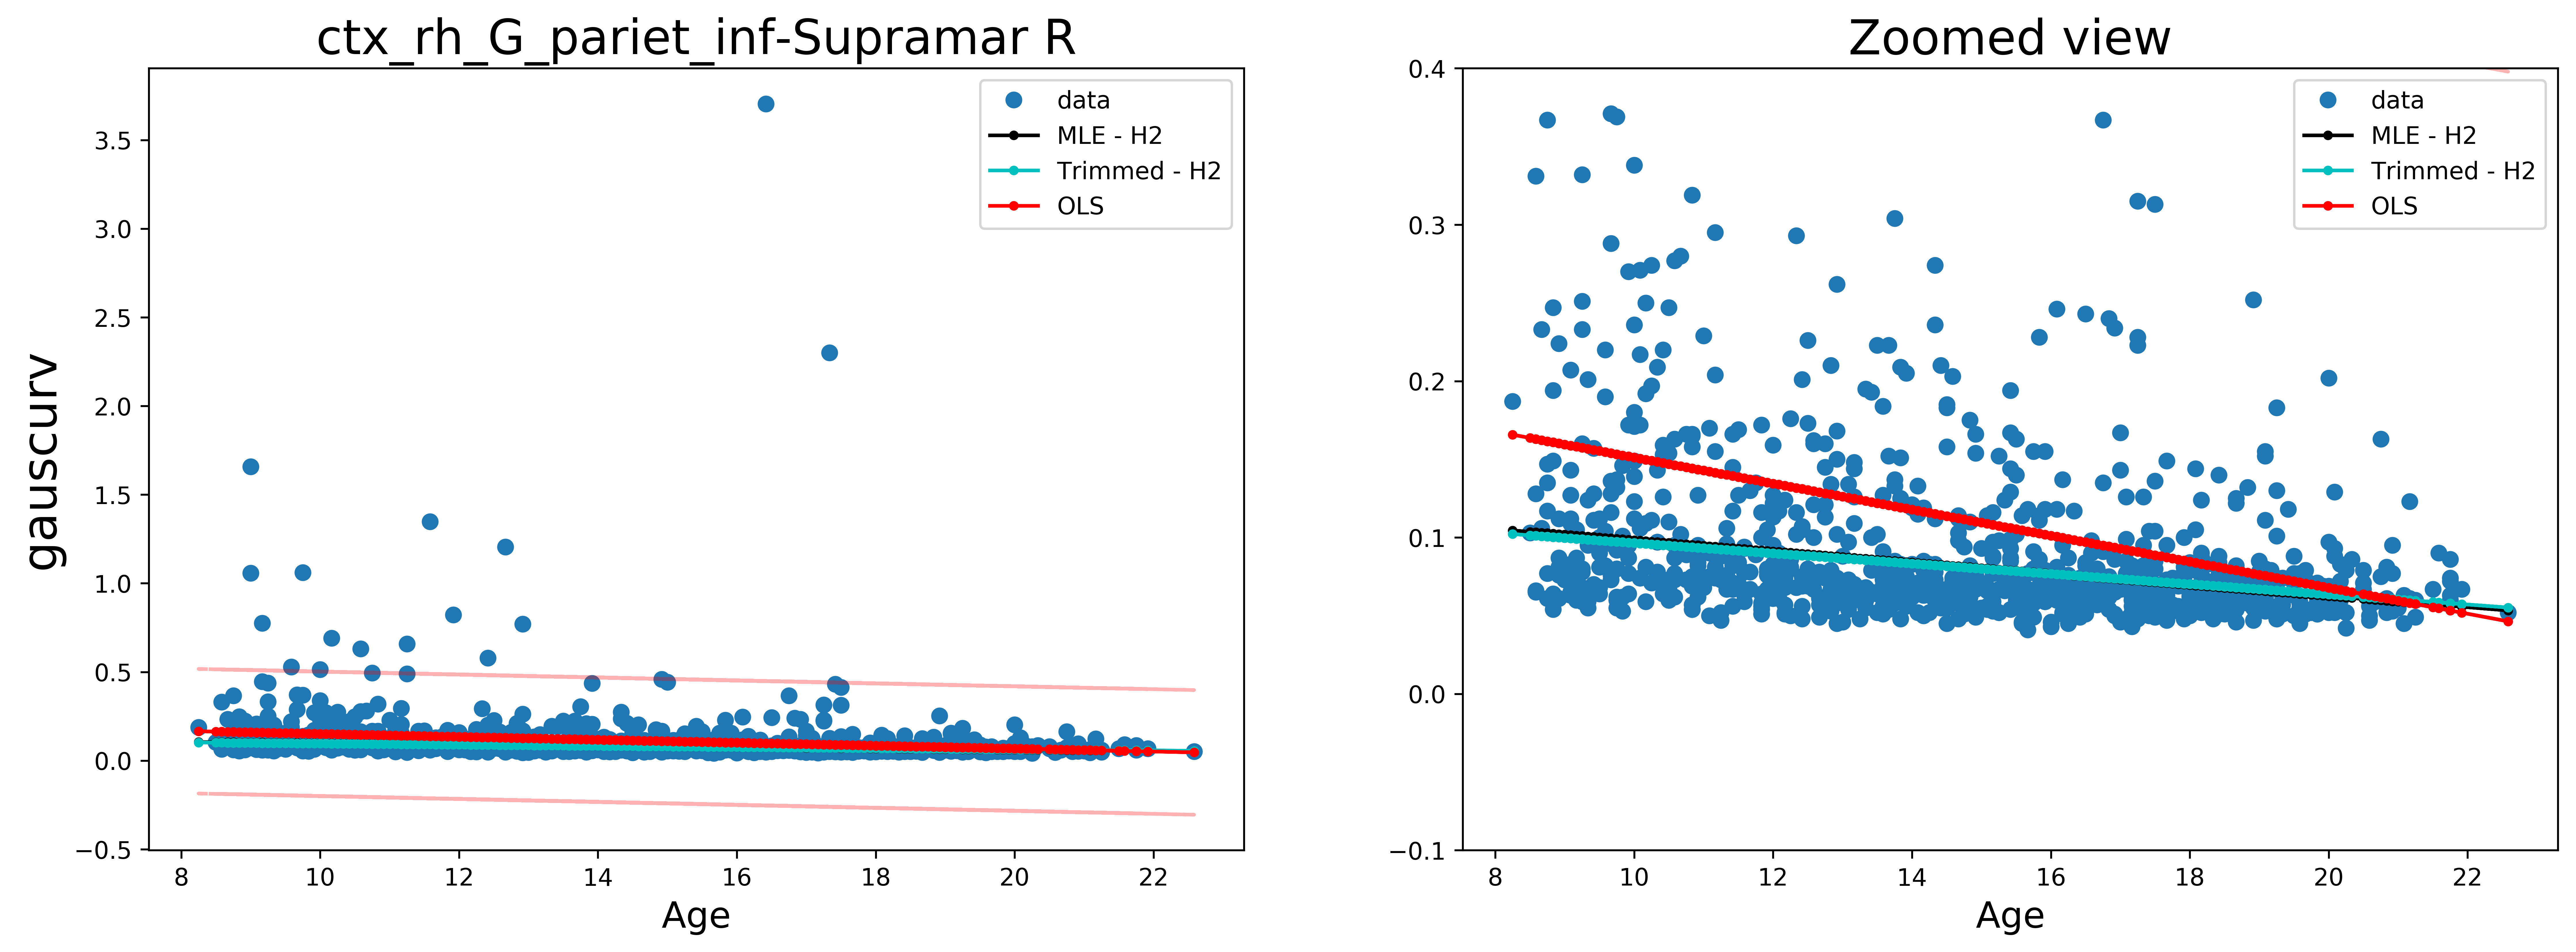

In [7]:
from statsmodels.sandbox.regression.predstd import wls_prediction_std

# create X and y
X = pd.concat([conf,pheno], axis=1)
X['intercept'] = np.ones((X.shape[0],1))
neuro_interest = 'FreeSurfer:FS_aparc_2009:ctx_rh_G_pariet_inf-Supramar:R:gauscurv:'
y = nimg[neuro_interest]
X.drop(['Race','eTIV','Gender'],axis=1,inplace=True)

# performing different fittings
huber_t = sm.RLM(y, X, M=sm.robust.norms.HuberT())
OLS = sm.OLS(y,X).fit()
hub_results = huber_t.fit(cov="H2")
andrew = sm.RLM(y, X, M=sm.robust.norms.AndrewWave())
andrew_results = andrew.fit(scale_est=sm.robust.scale.HuberScale(), cov="H3")

trimme = sm.RLM(y, X, M=sm.robust.norms.TrimmedMean())
trimme_results = trimme.fit(scale_est=sm.robust.scale.HuberScale(), cov="H3")

# gather and print results
compare = pd.concat([OLS.params,hub_results.params,andrew_results.params,trimme_results.params],axis=1)
compare.columns = ['OLS','HuberT','Wave','Trimmed']
print(compare)

# Plotting results
prstd, iv_l, iv_u = wls_prediction_std(OLS)
fig = plt.figure(figsize=(18,6),facecolor='white',dpi=600)
ax = fig.add_subplot(121)
ax.plot(X['Age']/12, y, 'o',label="data")
ax.plot(X['Age']/12, iv_u, 'r--',alpha = 0.3)
ax.plot(X['Age']/12, iv_l, 'r--',alpha = 0.3)
ax.plot(X['Age']/12, hub_results.fittedvalues, 'k.-', label="MLE - H2")
# ax.plot(X['Age']/12, andrew_results.fittedvalues, 'c.-', label="Wave - H2")
ax.plot(X['Age']/12, andrew_results.fittedvalues, 'c.-', label="Trimmed - H2")
ax.plot(X['Age']/12, OLS.fittedvalues, 'r.-', label="OLS")
ax.legend(loc="best",fontsize='medium')
plt.ylabel(neuro_interest.split(':')[4],size=20)
plt.xlabel('Age',size=15)
plt.title(' '.join(neuro_interest.split(':')[2:4]),size=20)

ax = fig.add_subplot(122)
ax.plot(X['Age']/12, y, 'o',label="data")
ax.plot(X['Age']/12, iv_u, 'r--',alpha = 0.3)
ax.plot(X['Age']/12, iv_l, 'r--',alpha = 0.3)
ax.plot(X['Age']/12, hub_results.fittedvalues, 'k.-', label="MLE - H2")
# ax.plot(X['Age']/12, andrew_results.fittedvalues, 'c.-', label="Wave - H3")
ax.plot(X['Age']/12, andrew_results.fittedvalues, 'c.-', label="Trimmed - H2")
ax.plot(X['Age']/12, OLS.fittedvalues, 'r.-', label="OLS")
ax.legend(loc="best",fontsize='medium')
plt.xlabel('Age',size=15)
plt.ylim((-0.1,0.4))
plt.title('Zoomed view',size=20)

plt.show()